In [1]:
import h5py
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

2023-11-04 11:30:21.165185: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-04 11:30:21.167230: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-04 11:30:21.196374: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-04 11:30:21.196400: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-04 11:30:21.196418: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
tf.keras.utils.set_random_seed(42)

In [3]:
with h5py.File('SVHN_single_grey1.h5', 'r') as file:
    x_train = np.array(file['X_train'])
    y_train = np.array(file['y_train'])
    x_test = np.array(file['X_test'])
    y_test = np.array(file['y_test'])
    x_val = np.array(file['X_val'])
    y_val = np.array(file['y_val'])

In [4]:
x_train[0].shape

(32, 32)

In [5]:
y_train.shape

(42000,)

In [6]:
# Load and preprocess the SVHN dataset
x_train, x_test, x_val = x_train / 255.0, x_test / 255.0, x_val / 255.0

In [7]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [8]:
# Constants
input_shape = x_train.shape[1:]
nClasses = 10

In [9]:
def createModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(nClasses,  activation='softmax'))

    return model

In [10]:
# Create the model
svhn_model = createModel()

In [11]:
# Display the summary of the model
print("SVHN Model Architecture:")
svhn_model.summary()

SVHN Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (N

In [12]:
AdamOpt = Adam(learning_rate=0.001)
svhn_model.compile(optimizer=AdamOpt,
                   loss='sparse_categorical_crossentropy',
                   metrics=['sparse_categorical_accuracy'])

In [13]:
batch_size = 256
epochs = 10

history = svhn_model.fit(x_train,
                         y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         class_weight=class_weight_dict,
                         validation_data=(x_val, y_val))

Epoch 1/10
165/165 [==============================] - 92s 552ms/step - loss: 2.4519 - sparse_categorical_accuracy: 0.1043 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/10
165/165 [==============================] - 93s 566ms/step - loss: 2.2051 - sparse_categorical_accuracy: 0.1613 - val_loss: 2.2498 - val_sparse_categorical_accuracy: 0.0988
Epoch 3/10
165/165 [==============================] - 94s 571ms/step - loss: 1.2325 - sparse_categorical_accuracy: 0.5646 - val_loss: 1.0029 - val_sparse_categorical_accuracy: 0.7014
Epoch 4/10
165/165 [==============================] - 95s 579ms/step - loss: 0.6444 - sparse_categorical_accuracy: 0.7984 - val_loss: 0.7236 - val_sparse_categorical_accuracy: 0.7732
Epoch 5/10
165/165 [==============================] - 93s 565ms/step - loss: 0.4815 - sparse_categorical_accuracy: 0.8575 - val_loss: 0.3613 - val_sparse_categorical_accuracy: 0.8883
Epoch 6/10
165/165 [==============================] - 93s 562ms/step - loss: 0.3787 -

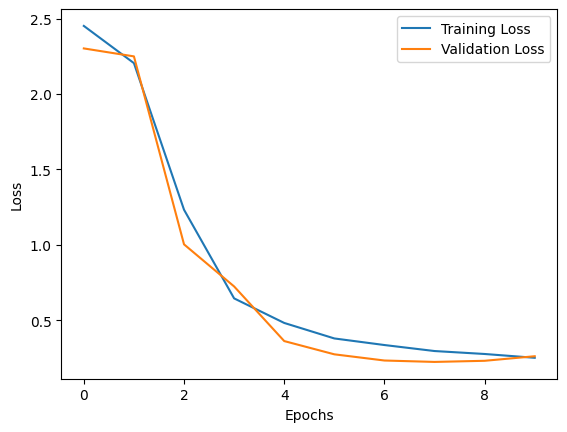

In [14]:
# Visualize training and validation errors
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Note we have started to over-fit (validation loss increases while training loss still decreases).

We can set the model to use early stopping based on increasing validation loss:

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

In [15]:
# Evaluate the model
test_loss, test_accuracy = svhn_model.evaluate(x_test, y_test)
print(f"\nSVHN Model - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

563/563 [==============================] - 11s 19ms/step - loss: 0.2992 - sparse_categorical_accuracy: 0.9106

SVHN Model - Test Loss: 0.299242228269577, Test Accuracy: 0.910611093044281


In [16]:
# Choose a few images for visualization
sample_images = x_test[:5]
sample_labels = y_test[:5]

In [17]:
# Visualize predictions
predictions = svhn_model.predict(sample_images)
predicted_labels = [tf.argmax(prediction).numpy() for prediction in predictions]

1/1 [==============================] - 0s 179ms/step


In [18]:
# Display the actual and predicted labels
print("\nActual Labels:", sample_labels)
print("Predicted Labels:", predicted_labels)


Actual Labels: [1 7 2 9 0]
Predicted Labels: [8, 7, 2, 9, 0]


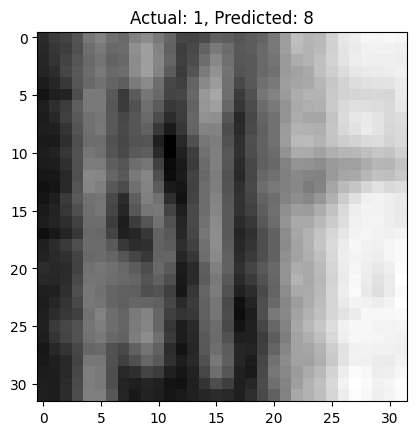

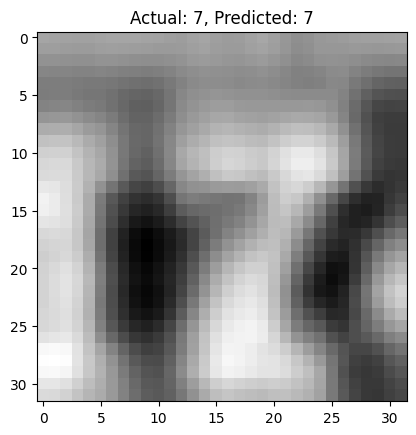

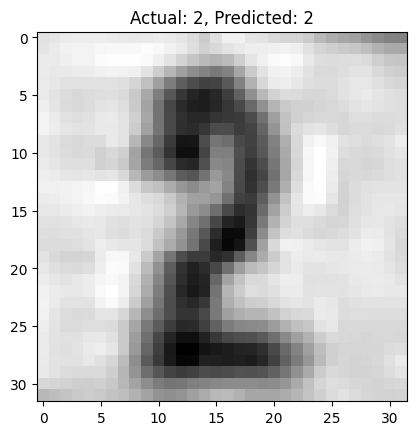

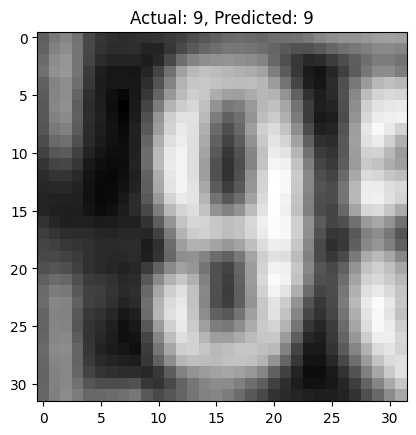

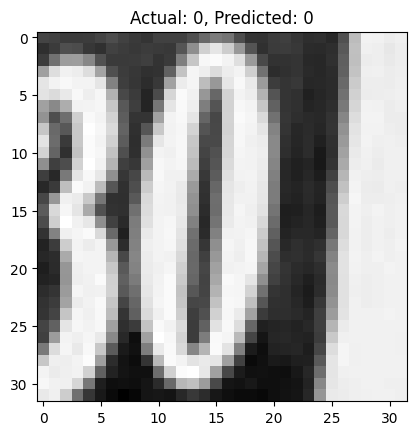

In [19]:
# Visualize sample images
for i in range(len(sample_images)):
    plt.figure()
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f"Actual: {sample_labels[i]}, Predicted: {predicted_labels[i]}")
    plt.show()